In [83]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import matplotlib.patheffects as pe

import pandas as pd
import logging as log
from stompy.grid import unstructured_grid
import glob
import re
from stompy import memoize
from stompy.plot import plot_wkb
import six
import stompy.plot.cmap as scmap

import os
from stompy import utils
import xarray as xr
%matplotlib notebook


In [139]:
from stompy.spatial import proj_utils 
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')


In [2]:
import postprocess_v00 as post
six.moves.reload_module(post)

<module 'postprocess_v00' from '/home/rusty/src/microplastic_sfbay/postprocess/postprocess_v00.py'>

In [3]:
grid_fn="/opt2/sfb_ocean/suntans/runs/merged_018_20171227/ptm_average.nc_0000.nc"  
grid=post.grid_from_ptm_hydro(grid_fn)
M=grid.smooth_matrix(f=0.5,dx='grid',A='grid',V='grid',K='scaled')

INFO:utils:60099/99089


In [4]:
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [5]:
def smooth(c): 
    for _ in range(20):
        c=M.dot(c)
    return c

In [6]:
#cmap=scmap.load_gradient('001-fire.cpt',reverse=True)
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

In [49]:
class BayConcFigure(object):
    figsize=(8.4,8)
    ax=None
    fig=None
    vmin=1e-5
    vmax=10.0
    zoom=(517521., 609000., 4139744., 4230000.)
    cmap=cmap
    cax_loc=[0.7,0.25,0.03,0.35]
    txt_loc=[0.65,0.7] # in ax coords
    cbar_label="Particles/m$^2$"
    cbar_args={} # don't modify - replace.
    draw_boundary=True
    fontsize=14
    extra_text=[]
    num=None
    def __init__(self,ds,conc=None,**kw):
        utils.set_keywords(self,kw)
        self.ds=ds
        if conc is None:
            conc=self.ds['conc'].values

        if self.fig is None:
            self.fig=plt.figure(figsize=self.figsize,num=self.num)
        if self.ax is None:
            self.ax=self.fig.add_subplot(1,1,1)
        
        self.ccoll=grid.plot_cells(values=conc.clip(self.vmin,self.vmax),
                                   cmap=self.cmap,norm=colors.LogNorm(vmin=self.vmin,vmax=self.vmax),
                                   edgecolor='face',lw=0.4,ax=self.ax)
        if self.draw_boundary:
            self.boundary=plot_wkb.plot_wkb(grid_poly,ax=self.ax,ec='k',lw=0.5,fc='none')
        if self.cax_loc is not None:
            self.cax=self.fig.add_axes(self.cax_loc) # Need refactor
            plt.colorbar(self.ccoll,cax=self.cax,label=self.cbar_label,extend='both',
                         **self.cbar_args)
        self.ax.axis('equal')
        self.ax.axis(self.zoom)
        self.ax.xaxis.set_visible(0)
        self.ax.yaxis.set_visible(0)
        self.fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01)
        
        self.add_labels()
    def __del__(self):
        try:
            self.ds.close()
        except AttributeError:
            pass
    def add_labels(self):
        texts=[self.behavior_label()]
        texts.append(self.average_label())
        texts.append(self.date_label())
        texts+=self.extra_text
        self.ax.text(self.txt_loc[0],self.txt_loc[1],"\n".join(texts),
                     fontsize=self.fontsize,va='top',ha='left',transform=self.ax.transAxes)
    def behavior_label(self):
        # go from a list of groups to a label
        behaviors=[ post.PtmRun.group_to_src_behavior(group)[1]
                    for group in self.ds.ptm_groups.values ]
        behaviors.sort()
        assert behaviors[0]==behaviors[-1]
        behavior=behaviors[0]
        if behavior=='none':
            label='Passive'
        elif behavior.startswith('up'):
            w_mmps=float(behavior.replace('up',''))/1000.0
            label=f'Rise {w_mmps:.1f} mm/s'
        elif behavior.startswith('down'):
            w_mmps=float(behavior.replace('down',''))/1000.0
            label=f'Settle {w_mmps:.1f} mm/s'
        return label
    
    def date_label(self):
        return self.date_label_ext(self.ds)
    @classmethod
    def date_label_ext(cls,ds):
        def fmt_t(t): return utils.to_datetime(t).strftime('%Y-%m-%d')
        return f"{fmt_t(ds.time_start)} – {fmt_t(ds.time_end)}"
    
    def average_label(self):
        return self.average_label_ext(self.ds)
    @classmethod
    def average_label_ext(cls,ds):
        if np.all(ds.z_range.values==[0,0.5]):
            return "Near bed"
        elif np.all(ds.z_range.values==[-0.5,0.0]):
            return "Near surface"
        elif np.all(ds.z_range.values==[0,0]):
            return "Full depth"
        else:
            return "Vertical range: %.2f – %.2f"%(ds.z_range.values[0],
                                                  ds.z_range.values[1])

# Same idea but settings for coastal region.
# note that with the 15 day output, these get truncated
# and show little action in the ocean.
class CoastalConcFigure(BayConcFigure):
    figsize=(7,8.1)
    zoom=(345000., 613202., 4050000., 4230105.)
    cax_loc=[0.05,0.20,0.03,0.35]
    txt_loc=[0.05,0.13] # in ax coords
    

In [15]:
# This should be the only place where version specific strings
# appear.

def single_fns():
    fns=glob.glob('processed/201*_201*/[-0-9]*/particles*-v07*.nc')
    fns.sort()
    fns=[fn
         for fn in fns
         if re.search(r'particles.*-v07(std|nofiber)\.nc',fn) is not None]
    return fns


def combined_fns():
    fns=glob.glob('processed/201*_201*/[-0-9]*/particles*-v07A*.nc')
    fns.sort()
    return fns

@memoize.memoize(lru=10)
def load_ptm_conc(ptm_conc):
    ds=xr.open_dataset(ptm_conc)
    conc=smooth(ds.conc.values)
    return ds,conc

@memoize.memoize(lru=10)
def load_combined(ptm_concA):
    ptm_concB=ptm_concA.replace('v07A','v07B')
    assert ptm_concB!=ptm_concA
    dsA=xr.open_dataset(ptm_concA)
    dsB=xr.open_dataset(ptm_concB)
    conc=smooth(dsA.conc.values+dsB.conc.values)
    # might need to shallow copy dsA and modify
    return dsA,conc


In [16]:
# The combined figures
display=False
force=False

if not display: plt.ioff()

for ptm_conc in single_fns():
    ds=None
    conc=None
    for config in ['bay','coast']:
        img_fn=ptm_conc.replace('.nc',f'-{config}.png')
        
        if (not display) and os.path.exists(img_fn) and not force: 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        if ds is None:
            ds=xr.open_dataset(ptm_conc)
        if conc is None:
            conc=smooth(ds.conc.values)
        if config=='bay':
            bf=BayConcFigure(ds,conc=conc)
        elif config=='coast':
            bf=CoastalConcFigure(ds,conc=conc)
        else:
            raise Exception(f"Bad config {config}")
        if display:
            break
        bf.fig.savefig(img_fn,dpi=150)
        plt.close(bf.fig)
    
if not display: plt.ion()

INFO:root:processed/20170630_20170715/-0.0005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-bed-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-bed-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170630_20170715/-0.0005/particles-surf-15d

INFO:root:processed/20170730_20170814/-0.0005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20170730_20170814/-0.0005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20170730_20170814/-0.0005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170730_20170814/-0.0005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170730_20170814/-0.0005/particles-surf-15days-v07std-bay.png: exists
INFO:root:processed/20170730_20170814/-0.0005/particles-surf-15days-v07std-coast.png: exists
INFO:root:processed/20170730_20170814/-0.005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170730_20170814/-0.005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170730_20170814/-0.005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20170730_20170814/-0.005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20170730_20170814/-0.005/particles-bed-15days-v07nofib

INFO:root:processed/20170830_20170914/-0.005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-bed-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-bed-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170830_20170914/-0.005/particles-surf-15days-v07std-

INFO:root:processed/20170930_20171015/-0.005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20170930_20171015/-0.005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20170930_20171015/-0.005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170930_20171015/-0.005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170930_20171015/-0.005/particles-surf-15days-v07std-bay.png: exists
INFO:root:processed/20170930_20171015/-0.005/particles-surf-15days-v07std-coast.png: exists
INFO:root:processed/20170930_20171015/-0.05/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20170930_20171015/-0.05/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20170930_20171015/-0.05/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20170930_20171015/-0.05/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20170930_20171015/-0.05/particles-bed-15days-v07nofiber-bay.png:

INFO:root:processed/20171030_20171114/-0.05/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-bed-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-bed-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171030_20171114/-0.05/particles-surf-15days-v07std-bay.png: ex

INFO:root:processed/20171130_20171215/-0.05/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20171130_20171215/-0.05/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20171130_20171215/-0.05/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171130_20171215/-0.05/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171130_20171215/-0.05/particles-surf-15days-v07std-bay.png: exists
INFO:root:processed/20171130_20171215/-0.05/particles-surf-15days-v07std-coast.png: exists
INFO:root:processed/20171130_20171215/0.0/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171130_20171215/0.0/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171130_20171215/0.0/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20171130_20171215/0.0/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20171130_20171215/0.0/particles-bed-15days-v07nofiber-bay.png: exists
INFO:roo

INFO:root:processed/20171230_20180114/0.0/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-bed-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-bed-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20171230_20180114/0.0/particles-surf-15days-v07std-bay.png: exists
INFO:root:process

INFO:root:processed/20180130_20180214/0.0/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20180130_20180214/0.0/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20180130_20180214/0.0/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180130_20180214/0.0/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180130_20180214/0.0/particles-surf-15days-v07std-bay.png: exists
INFO:root:processed/20180130_20180214/0.0/particles-surf-15days-v07std-coast.png: exists
INFO:root:processed/20180130_20180214/0.0005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180130_20180214/0.0005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180130_20180214/0.0005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20180130_20180214/0.0005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20180130_20180214/0.0005/particles-bed-15days-v07nofiber-bay.png: exists
INFO:

INFO:root:processed/20180302_20180317/0.0005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-bed-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-bed-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180302_20180317/0.0005/particles-surf-15days-v07std-

INFO:root:processed/20180330_20180414/0.0005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20180330_20180414/0.0005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20180330_20180414/0.0005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180330_20180414/0.0005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180330_20180414/0.0005/particles-surf-15days-v07std-bay.png: exists
INFO:root:processed/20180330_20180414/0.0005/particles-surf-15days-v07std-coast.png: exists
INFO:root:processed/20180330_20180414/0.005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180330_20180414/0.005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180330_20180414/0.005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20180330_20180414/0.005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20180330_20180414/0.005/particles-bed-15days-v07nofiber-bay.png:

INFO:root:processed/20180430_20180515/0.005/particles-avg-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-avg-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-avg-15days-v07std-coast.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-bed-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-bed-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-surf-15days-v07nofiber-bay.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-surf-15days-v07nofiber-coast.png: exists
INFO:root:processed/20180430_20180515/0.005/particles-surf-15days-v07std-bay.png: ex

INFO:root:processed/20180530_20180614/0.005/particles-bed-15days-v07nofiber-coast.png: processing
INFO:root:processed/20180530_20180614/0.005/particles-bed-15days-v07std-bay.png: exists
INFO:root:processed/20180530_20180614/0.005/particles-bed-15days-v07std-coast.png: exists
INFO:root:processed/20180530_20180614/0.005/particles-surf-15days-v07nofiber-bay.png: processing
INFO:root:processed/20180530_20180614/0.005/particles-surf-15days-v07nofiber-coast.png: processing
INFO:root:processed/20180530_20180614/0.005/particles-surf-15days-v07std-bay.png: exists
INFO:root:processed/20180530_20180614/0.005/particles-surf-15days-v07std-coast.png: exists
INFO:root:processed/20180530_20180614/0.05/particles-avg-15days-v07nofiber-bay.png: processing
INFO:root:processed/20180530_20180614/0.05/particles-avg-15days-v07nofiber-coast.png: processing
INFO:root:processed/20180530_20180614/0.05/particles-avg-15days-v07std-bay.png: exists
INFO:root:processed/20180530_20180614/0.05/particles-avg-15days-v07st

In [17]:
display=False
if not display: plt.ioff()

for ptm_concA in combined_fns():
    for config in ['bay','coast']:
        img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA).replace('.nc',f'-{config}.png')
    
        if (not display) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        ds,conc=load_combined(ptm_concA)
        kw=dict(extra_text=['44 day cutoff'])
        if config=='bay':
            bf=BayConcFigure(ds,conc=conc,txt_loc=[0.65,0.75],**kw)
        elif config=='coast':
            bf=CoastalConcFigure(ds,conc=conc,**kw)
        else:
            raise Exception(f"Bad config {config}")
        if not display:
            bf.fig.savefig(img_fn,dpi=150)
            plt.close(bf.fig)
    if display:
        break
    
if not display: plt.ion()

INFO:root:processed/20170729_20170812/-0.0005/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170729_20170812/-0.0005/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170729_20170812/-0.000

INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20170828_20170911/-0.0005/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20170828_20170911/-0.005/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170828_20170911/-0.005/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170828_20170911/-0.005

INFO:root:processed/20170928_20171012/-0.0005/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170928_20171012/-0.0005/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170928_20171012/-0.0005/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20170928_20171012/-0.0005/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20170928_20171012/-0.005/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20170928_20171012/-0.005/par

INFO:root:processed/20171029_20171112/-0.005/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171029_20171112/-0.005/particles

INFO:root:processed/20171128_20171212/-0.005/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20171128_20171212/-0.005/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20171128_20171212/-0.05/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171128_20171212/-0.05/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171128_20171212/-0.05/particles-

INFO:root:processed/20171229_20180112/-0.005/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171229_20180112/-0.005/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171229_20180112/-0.005/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20171229_20180112/-0.005/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20171229_20180112/-0.05/particles-bed-

INFO:root:processed/20180128_20180211/-0.05/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180128_20180211/-0.05/particles-surf-44day

INFO:root:processed/20180228_20180314/-0.05/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180228_20180314/-0.05/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180228_20180314/0.0/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180228_20180314/0.0/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180228_20180314/0.0/particles-avg-44days-v07

INFO:root:processed/20180331_20180414/-0.05/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180331_20180414/-0.05/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180331_20180414/-0.05/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180331_20180414/-0.05/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180331_20180414/0.0/particles-bed-44days-v07ABstd-ba

INFO:root:processed/20180428_20180512/0.0/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-avg-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-avg-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180428_20180512/0.0/particles-surf-44days-v07ABstd-bay.png: ex

INFO:root:processed/20180529_20180612/0.0/particles-bed-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-bed-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-bed-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-bed-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-surf-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-surf-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-surf-44days-v07ABstd-bay.png: exists
INFO:root:processed/20180529_20180612/0.0/particles-surf-44days-v07ABstd-coast.png: exists
INFO:root:processed/20180529_20180612/0.0005/particles-avg-44days-v07ABnofiber-bay.png: exists
INFO:root:processed/20180529_20180612/0.0005/particles-avg-44days-v07ABnofiber-coast.png: exists
INFO:root:processed/20180529_20180612/0.0005/particles-avg-44days-v07ABstd-b

In [54]:
class MissingFiles(Exception): pass

class WsPanels(object):
    all_w_s=["-0.05","-0.005","-0.0005",
             "0.0",
             "0.0005","0.005","0.05"]
    figsize=(8.4,8)
    num=None
    PlotClass=BayConcFigure
    shape=(3,3)
    # weird python rules - tries to make this an instance method.
    panel_labeler=staticmethod(lambda i: "abcdefghijkl"[i])
    # for text label in each panel
    panel_txt_loc=[0.45,0.73]
    
    def loader(self,ptm_conc):
        return load_ptm_conc(ptm_conc)
    
    @classmethod
    def expand_ptm_conc(cls,ptm0_conc):
        ptm_concs=[ptm0_conc.replace("/0.0/","/"+w_s+"/")
                   for w_s in cls.all_w_s]
        if not all([os.path.exists(fn) for fn in ptm_concs]):
            log.warning("{ptm_conc} did not have all w_s - skip")
            raise MissingFiles()
        return ptm_concs
    
    def __init__(self,ptm0_conc,**kw):
        """
        ptm0_conc: path to the w_s=0.0 netcdf file.
        assumes that /0.0/ appears in the path, and
        can be replaced by the other settling velocities
        """
        utils.set_keywords(self,kw)
        
        ptm_concs=self.expand_ptm_conc(ptm0_conc)
        
        if self.num is not None:
            fig=plt.figure(figsize=self.figsize,num=self.num)
            fig.clf()
            fig.set_size_inches(self.figsize,forward=True)            
        self.fig,self.axs=plt.subplots(self.shape[0],self.shape[1],
                                       num=self.num,figsize=self.figsize)
        
        self.bfs=[]
        sum_conc=0.0
        for w_s,ptm_conc,ax in zip(self.all_w_s+['sum'],
                                   ptm_concs+['sum'],
                                   self.axs.ravel()):
            kw={}
            # Monkeys!
            kw['average_label']=lambda: ""
            kw['date_label']=lambda: ""
            if ptm_conc!=ptm_concs[0]:
                kw['cax_loc']=None
            else:
                # kw['cax_loc']=[0.68,0.03,0.02,0.28]
                kw['cax_loc']=[0.68,0.13,0.30,0.02]
                kw['cbar_args']={'orientation':'horizontal'}
            kw['txt_loc']=self.panel_txt_loc
            kw['fontsize']=12

            if ptm_conc=='sum':
                conc=sum_conc
                kw['behavior_label']=lambda: "Sum"
            else:
                ds,conc=self.loader(ptm_conc)
                sum_conc = sum_conc + conc
            bf=self.PlotClass(ds,conc=conc,ax=ax,fig=self.fig,**kw)
            self.bfs.append(bf)
            
        self.fig.subplots_adjust(hspace=0.0,wspace=0.0)
        ax=self.axs.ravel()[-1]
        plt.setp(ax.spines.values(),visible=0)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)
        
        sum_txts=[bf.date_label_ext(bf.ds),
                  bf.average_label_ext(bf.ds)]
        ax.text(0.10,0.90,"\n".join(sum_txts),transform=ax.transAxes,
               va='top',fontsize=12)
        # This is to avoid overwriting the neighboring spines.
        ax.patch.set_facecolor('none')
        
        if self.panel_labeler is not None:
            self.label_panels(self.axs.ravel()[:8])
    panel_label_loc=[0.05,0.9]
    panel_label_kw={'va':'top','fontsize':12,'fontweight':'bold'}
    def label_panels(self,axs):
        for i,ax in enumerate(axs):
            txt=self.panel_labeler(i)
            ax.text(self.panel_label_loc[0],self.panel_label_loc[1],txt,
                    transform=ax.transAxes,**self.panel_label_kw)
        
class WsPanelsCoastal(WsPanels):
    panel_label_loc=[0.02,0.16]
    panel_txt_loc=[0.02,0.08]
    PlotClass=CoastalConcFigure

In [57]:
# 8-panel plots
# Bay and coast
# show each of the settling velocities, and a summation.

display=False
force=True

if not display: plt.ioff()

# starts with 15 day datasets -- pull passive, and generate the
# rest

# filter the original list down to just the passive
#fns=glob.glob('processed/201*_201*/0.0/particles*-vNN.nc')
#fns.sort()

for ptm_conc in single_fns():
    if "/0.0/" not in ptm_conc:
        continue    
    if ('20170830' not in ptm_conc) and ('20180302' not in ptm_conc):
        print("TMP")
        continue
    for config in ['bay','coast']:
        img_fn=ptm_conc.replace("0.0/","").replace('.nc',f'-{config}-8panel.png')
        if (not display) and os.path.exists(img_fn) and not force: 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        if config=='coast':
            pf=WsPanelsCoastal(ptm_conc)
        else:
            pf=WsPanels(ptm_conc)
        if display:
            break
        pf.fig.savefig(img_fn,dpi=150)
        plt.close(pf.fig)
    if display:
        break
if not display: plt.ion()

INFO:root:processed/20170830_20170914/particles-avg-15days-v07nofiber-bay-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


INFO:root:processed/20170830_20170914/particles-avg-15days-v07nofiber-coast-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-avg-15days-v07std-bay-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-avg-15days-v07std-coast-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-bed-15days-v07nofiber-bay-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-bed-15days-v07nofiber-coast-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-bed-15days-v07std-bay-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-bed-15days-v07std-coast-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-surf-15days-v07nofiber-bay-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-surf-15days-v07nofiber-coast-8panel.png: processing
INFO:root:processed/20170830_20170914/particles-surf-15days-v07std-bay-8panel.png: processing
INFO:root:processed/20170830_20170914

TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


INFO:root:processed/20180302_20180317/particles-avg-15days-v07nofiber-coast-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-avg-15days-v07std-bay-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-avg-15days-v07std-coast-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-bed-15days-v07nofiber-bay-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-bed-15days-v07nofiber-coast-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-bed-15days-v07std-bay-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-bed-15days-v07std-coast-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-surf-15days-v07nofiber-bay-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-surf-15days-v07nofiber-coast-8panel.png: processing
INFO:root:processed/20180302_20180317/particles-surf-15days-v07std-bay-8panel.png: processing
INFO:root:processed/20180302_20180317

TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


In [62]:
# Combined, panels
display=False
force=True

if not display:
    plt.ioff()
else:
    plt.ion()
for ptm_concA in combined_fns():
    if "/0.0/" not in ptm_concA:
        continue
    if ('20170828' not in ptm_concA) and ('20180228' not in ptm_concA):
        print("TMP")
        continue
    
    for config in ['coast']: # ['bay','coast']:
        img_fn=re.sub(r'(v\d\d)A',r'\1AB',ptm_concA)
        img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-8panel.png')
    
        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue
        log.info(f"{img_fn}: processing")
        #ds,conc=load_combined(ptm_concA)
        kw=dict(extra_text=['44 day cutoff'])
        
        if config=='coast':
            pf=WsPanelsCoastal(ptm_concA,loader=load_combined)
        else:
            pf=WsPanels(ptm_concA,loader=load_combined)
        if display:
            break
        pf.fig.savefig(img_fn,dpi=150)
        plt.close(pf.fig)
    if display:
        break
if not display:
    plt.ion()
    

INFO:root:processed/20170828_20170911/particles-avg-44days-v07ABnofiber-coast-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP


INFO:root:processed/20170828_20170911/particles-avg-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-bed-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-bed-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-surf-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20170828_20170911/particles-surf-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-avg-44days-v07ABnofiber-coast-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


INFO:root:processed/20180228_20180314/particles-avg-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-bed-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-bed-44days-v07ABstd-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-surf-44days-v07ABnofiber-coast-8panel.png: processing
INFO:root:processed/20180228_20180314/particles-surf-44days-v07ABstd-coast-8panel.png: processing


TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP
TMP


In [63]:
# Plot a sum, surface plot vs. the manta
manta_std=pd.read_csv('manta_summary-v01std.csv')
manta_nofiber=pd.read_csv('manta_summary-v01nofiber.csv')

split_fields=('SampleID','part_per_m2','part_per_m3')
common_fields=('SampleID','SampleType','x','y','Season','area_m2')
manta_combined=pd.merge(manta_std.loc[:, split_fields],
                        manta_nofiber.loc[:, split_fields],
                        left_on='SampleID',right_on='SampleID',
                        how='outer',suffixes=['_std','_nofiber'])
manta=pd.merge(manta_std.loc[:,common_fields],
               manta_combined,
               left_on='SampleID',right_on='SampleID')
manta.head()

,SampleID,SampleType,x,y,Season,area_m2,part_per_m2_std,part_per_m3_std,part_per_m2_nofiber,part_per_m3_nofiber
0,CB-4-Manta-21Aug2017,Trawl,550326.816800,4.197530e+06,Dry,2118.727190,0.032147,0.338391,0.001180,0.012421
1,CB4-Manta-16Nov2017,Trawl,550326.816800,4.197530e+06,Wet,1081.727744,0.580758,6.113244,0.579936,6.104594
2,CB5-Manta-16Nov2017,Trawl,552177.481202,4.188548e+06,Wet,1408.382016,0.179087,1.885121,0.178455,1.878478
3,CB5-Manta-22Aug2017,Trawl,552177.481202,4.188548e+06,Dry,1447.658557,0.041600,0.437892,0.040986,0.431429
4,CB5-Manta-5Nov2017,Trawl,552177.481202,4.188548e+06,Dry,1866.537295,0.304843,3.208869,0.030895,0.325211


INFO:root:Saved image to processed/20180302_20180317/particles-surf-15days-v07std-coast-vs_manta-15days.png
INFO:root:Saved image to processed/20170830_20170914/particles-surf-15days-v07std-coast-vs_manta-15days.png
INFO:root:Saved image to processed/20180228_20180314/particles-surf-44days-v07ABstd-coast-vs_manta-44days.png
INFO:root:Saved image to processed/20170828_20170911/particles-surf-44days-v07ABstd-coast-vs_manta-44days.png
INFO:root:Saved image to processed/20180302_20180317/particles-surf-15days-v07nofiber-coast-vs_manta-15days.png
INFO:root:Saved image to processed/20170830_20170914/particles-surf-15days-v07nofiber-coast-vs_manta-15days.png
INFO:root:Saved image to processed/20180228_20180314/particles-surf-44days-v07ABnofiber-coast-vs_manta-44days.png
INFO:root:Saved image to processed/20170828_20170911/particles-surf-44days-v07ABnofiber-coast-vs_manta-44days.png


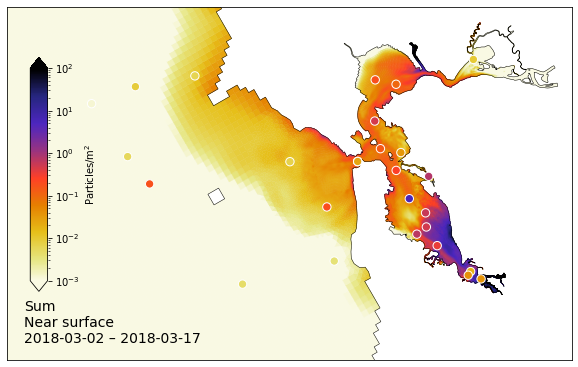

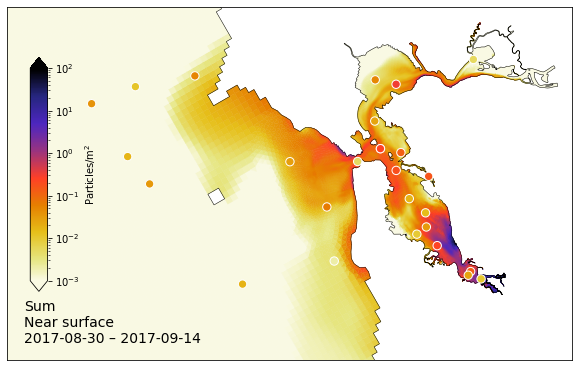

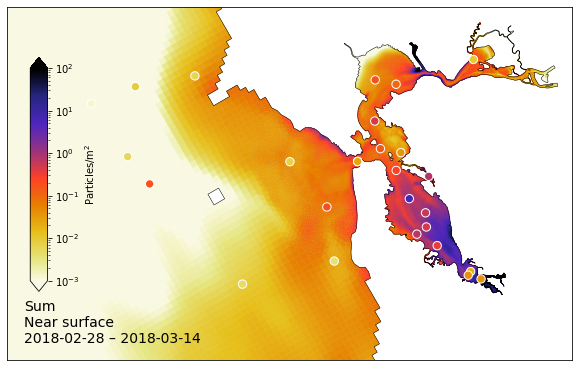

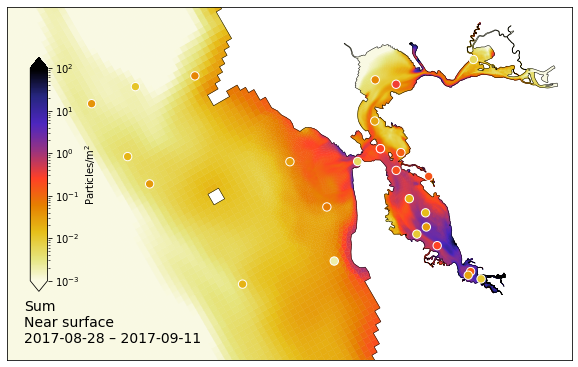

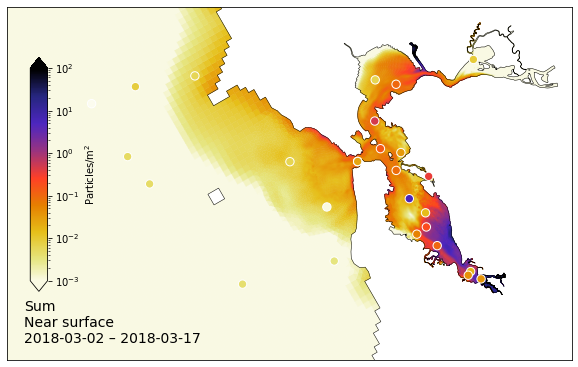

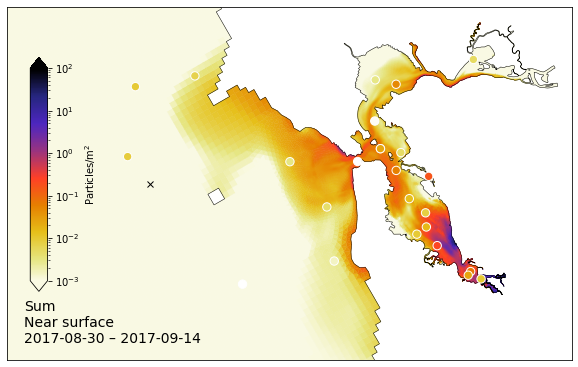

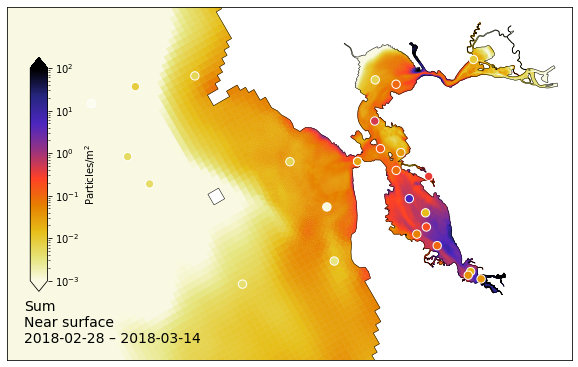

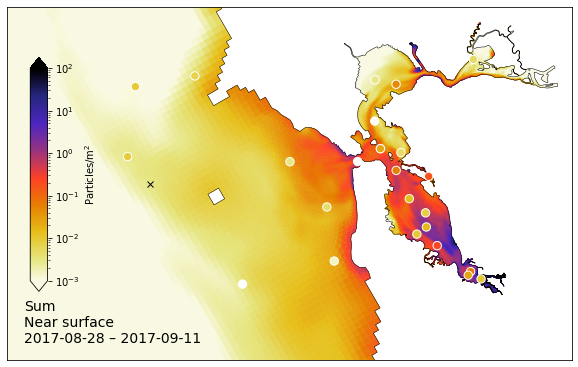

In [66]:
# So I want a sum concentration representative of wet weather.
# either 2/28 or 3/02.
# how the 2/28, 44 dayer.
display=False
force=True
max_age=15

for sub_version in ['std','nofiber']:
    for max_age in [15,44]:
        for season in ['Wet','Dry']:
            # find the base ptm_conc
            kw={}
            if max_age==44:
                fns=combined_fns()
                loader=load_combined
                kw['extra_text']=['44 day cutoff']
            elif max_age==15:
                fns=single_fns()
                loader=load_ptm_conc
            else:
                raise Exception(f"Wha kind of max age is {max_age}")

            for ptm_concA in fns:
                if "/0.0/" not in ptm_concA:
                    continue
                if sub_version not in ptm_concA:
                    continue
                if ( (season=='Wet') and 
                     ('20180228' not in ptm_concA) and
                     ('20180302' not in ptm_concA) ):
                    continue
                if ( (season=='Dry') and 
                     ('20170828' not in ptm_concA) and
                     ('20170830' not in ptm_concA) ):
                    continue
                if 'surf' not in ptm_concA:
                    continue

                config='coast'
                img_fn=ptm_concA
                if max_age>15: # i.e. it has A and B parts
                    img_fn=re.sub('(v\d\d)A',r'\1AB',ptm_concA) # .replace('vNNA','vNNAB45')
                img_fn=img_fn.replace("0.0/","").replace('.nc',f'-{config}-vs_manta-{max_age}days.png')

                if (not display) and (not force) and os.path.exists(img_fn): 
                    log.info(f"{img_fn}: exists")
                    continue
                break
            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc=conc+conc_one

            fig,ax=plt.subplots(1,1,figsize=(8,5))

            F=CoastalConcFigure(ds,conc,vmin=1e-3,vmax=1e2,fig=fig,ax=ax,
                                behavior_label=lambda: "Sum",
                                txt_loc=[0.03,0.17],
                                cax_loc=[0.05,0.2,0.03,0.65])
            ax.axis('equal')
            # Plot the manta data.
            conc_field='part_per_m2_'+sub_version
            manta_sel=manta[ (manta.SampleType=='Trawl') & (manta.Season==season) ]
            bad=manta_sel[conc_field]<=0.0
            vmin=1e-3
            ax.scatter(manta_sel['x'][~bad],
                       manta_sel['y'][~bad],
                       70,
                       manta_sel[conc_field][~bad],
                       cmap='CMRmap_r',
                       edgecolors='w',
                       norm=colors.LogNorm(vmin=vmin,vmax=100),zorder=3)
            ax.plot(manta_sel['x'][bad],
                    manta_sel['y'][bad],
                    'kx')
            # Annotate what the typical minimum possible concentration is --
            # i.e. 1 particle in the whole sample volume.
            mdl=1./ np.median(manta.area_m2) # manta.volume_l/1000.
            if mdl>vmin:
                F.cax.axhline(mdl,color='k')
    
            ax.axis( (430820., 614360., 4119898., 4234611.) )
            fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
            if display: break
        if display: break
    if display:
        break
            

In [67]:
sed_std=pd.read_csv('sed_data_grouped-v01std.csv',index_col=0)
sed_nofiber=pd.read_csv('sed_data_grouped-v01nofiber.csv',index_col=0)

split_fields=('part_per_mass','part_per_mass_raw')
common_fields=('x','y')

sed_combined=pd.merge(sed_std.loc[:,split_fields],
                      sed_nofiber.loc[:,split_fields],
                      left_index=True,right_index=True,
                      how='outer',suffixes=['_std','_nofiber'])

sed=pd.merge(sed_std.loc[:,common_fields],sed_combined,
            left_index=True,right_index=True)
sed['name']=sed.index.values
sed.head()

,x,y,part_per_mass_std,part_per_mass_raw_std,part_per_mass_nofiber,part_per_mass_raw_nofiber,name
Central Bay,555693.0,4190807.0,2.791345,3.378813,1.565668,1.675333,Central Bay
Lower South Bay,581612.0,4148286.0,25.411375,28.760634,4.131815,5.599725,Lower South Bay
San Pablo Bay,553500.0,4213639.0,2.271236,2.893780,0.926732,1.152965,San Pablo Bay
South Bay,564992.0,4166840.0,1.120053,1.657012,0.306606,0.346021,South Bay
Southern Sloughs,587722.0,4144760.0,16.319796,21.652645,5.399812,6.602342,Southern Sloughs


In [142]:
utils.path("../field_data")
import plastic_data
sed_df=plastic_data.sediment_df
sed_df=sed_df[ sed_df['field_sample_p']]

grped=sed_df.groupby('SampleID')
lat=grped['ActualLatitude'].first()
lon=grped['ActualLongitude'].first()
ll=np.c_[lon,lat]
sed_xy=ll2utm(ll)

<IPython.core.display.Javascript object>


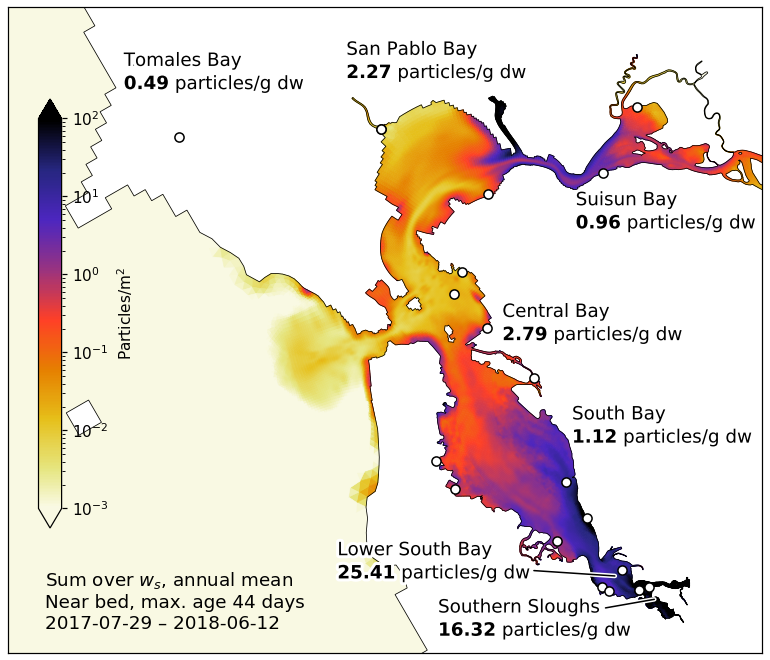

<IPython.core.display.Javascript object>


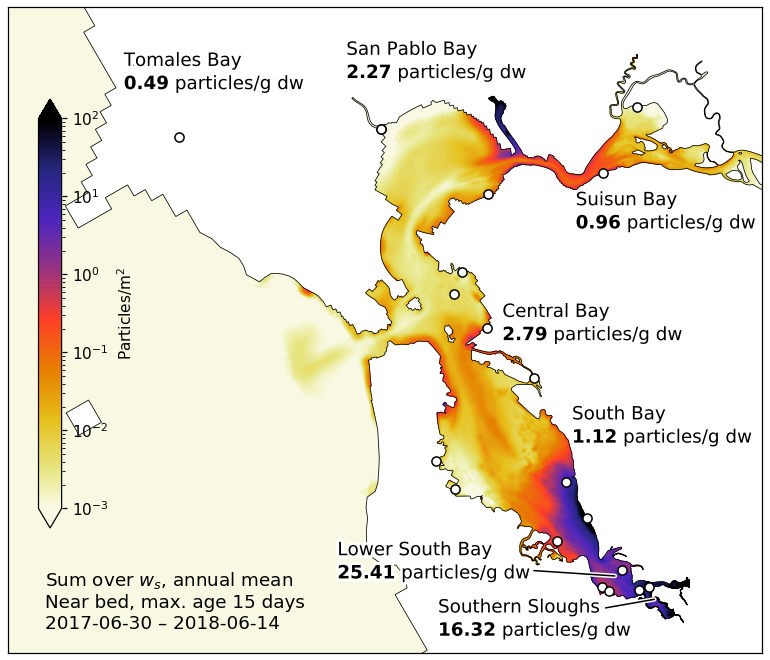

<IPython.core.display.Javascript object>


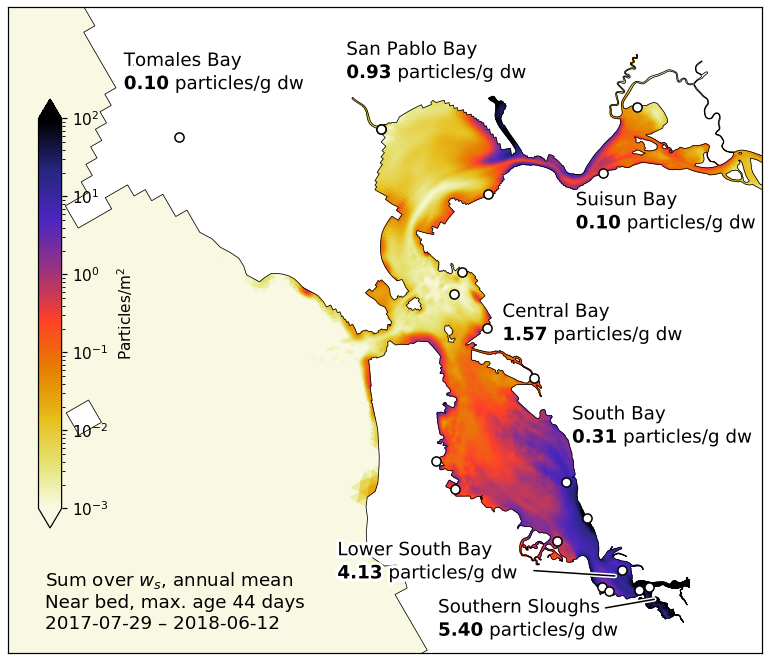

<IPython.core.display.Javascript object>


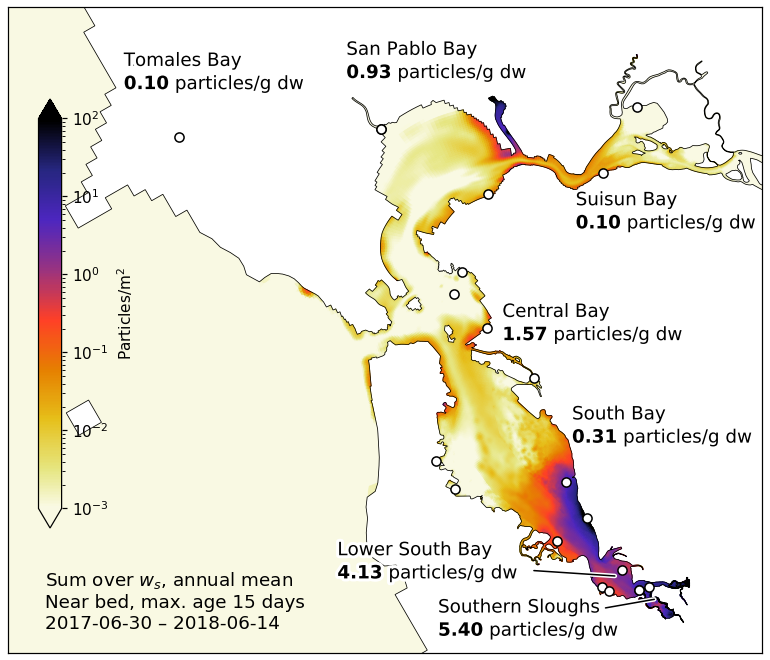

In [149]:
# average across all available.
display=True
force=True

if display: plt.ion()
else: plt.ioff()

for sub_version in ['std','nofiber']:
    for max_age in [44,15]:
        conc_accum=0.0 # accumulate concentrations for average.
        Naccum=0 # count how many fields have been added in here.

        t_min=None
        t_max=None

        # find the base ptm_conc
        if max_age==44:
            fns=combined_fns()
            loader=load_combined
        else:
            fns=single_fns()
            loader=load_ptm_conc

        for ptm_concA in fns:
            if "/0.0/" not in ptm_concA:
                continue
            if 'bed' not in ptm_concA:
                continue
            if sub_version not in ptm_concA:
                continue

            # Get the full list of all settling velocities
            ptm_concs=WsPanels.expand_ptm_conc(ptm_concA)
            # Sum to get one concentration.
            conc_sum=0.0
            for ptm_conc in ptm_concs:
                ds,conc_one=loader(ptm_conc)
                conc_sum=conc_sum+conc_one
                if t_min is None or t_min>ds.time_start:
                    t_min=ds.time_start
                if t_max is None or t_max<ds.time_end:
                    t_max=ds.time_end
            conc_accum=conc_accum+conc_sum
            Naccum+=1

            # grab the config naming while we have the filename
            model_data_label=re.sub(r'.*-(v.*)\.nc',r'\1',ptm_concA)

        conc_mean = conc_accum / Naccum
        ds=ds.copy()
        ds['time_start']=(),t_min
        ds['time_end']=(),t_max

        img_fn=f"processed/sediment-bed-{model_data_label}-{config}-{max_age}days.png"

        if (not display) and (not force) and os.path.exists(img_fn): 
            log.info(f"{img_fn}: exists")
            continue

        F=CoastalConcFigure(ds,conc_mean,vmin=1e-3,vmax=1e2,
                            behavior_label=lambda: "Sum over $w_s$, annual mean",
                            average_label=lambda: f"Near bed, max. age {max_age} days",
                            figsize=(7,6),
                            cax_loc=[0.05,0.2,0.03,0.65],
                            fontsize=12,
                            zoom=[487000., 604000., 4136255., 4237015.])

        if 1:
            # kludgy label postioning.
            sed['xoff']=0.0 ; sed['yoff']=0.0
            sed.loc['San Pablo Bay','yoff']=12000
            sed.loc['San Pablo Bay','xoff']=-6000 - 8000
            sed.loc['Suisun Bay','yoff']=-10000 - 4000
            sed.loc['Suisun Bay','xoff']=-15000 + 7000
            sed.loc['Central Bay','xoff']=18000 - 10000
            sed.loc['Central Bay','yoff']=-6000
            sed.loc['Tomales Bay','xoff']=6000 - 10000
            sed.loc['South Bay','yoff']=2000
            sed.loc['South Bay','xoff']=21000 - 11500
            sed.loc['Lower South Bay','xoff']=-18500 - 25000
            sed.loc['Lower South Bay','yoff']=-600
            sed.loc['Southern Sloughs','xoff']=-18000 - 16000
            sed.loc['Southern Sloughs','yoff']=-3000 - 3000

            # more kludge.  these map region labels to an optional
            #  callout line.  the coordinates are an offset from the text 
            #  location for the start of the line.  the end of the line
            #  is the dataset coordinates for the region (mean of sample locations).
            arrows={'Lower South Bay':[30e3,1.5e3],
                    'Southern Sloughs':[25.5e3,4.5e3]
            }
            
            conc_field='part_per_mass_'+sub_version
            for idx,row in sed.iterrows():
                F.ax.text(row['x']+row['xoff'],row['y']+row['yoff'],
                          f"{row['name']}\n$\mathbf{{ {row[conc_field]:.2f} }}$ particles/g dw",
                          fontsize=12,
                          path_effects=[pe.withStroke(linewidth=4, foreground="white")],
                          ha='left')
                if idx in arrows: # additionally add a callout arrow
                    axy=arrows[idx]
                    ann=F.ax.annotate("",
                                      xy=(row['x'],row['y']), xycoords='data',
                                      xytext=(axy[0]+row['x']+row['xoff'],
                                              axy[1]+row['y']+row['yoff']),
                                      textcoords='data',
                                      arrowprops=dict(arrowstyle="-",color='k',
                                                      connectionstyle="arc3"),
                                    )
                    ann.arrow_patch.set_path_effects([pe.Stroke(linewidth=3, foreground="w"),
                                                      pe.Normal()])
        if 1:
            # Show locations of individual samples
            F.ax.plot(sed_xy[:,0],sed_xy[:,1],
                      ls='none',marker='o',color='w',markeredgecolor='k')



        F.ax.axis(F.zoom)
        if not display:
            F.fig.savefig(img_fn,dpi=150)
            log.info(f"Saved image to {img_fn}")
        #if display: break
    #if display: break
        
if not display: plt.ion()


In [146]:
F.ax.lines=[]
        
        

In [144]:
F.ax.lines